the goal here is to set up barebones inference framework. things needed:
- data vector
- simulator or likelihood
- chainconsumer for posterior plotting

In [43]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

%matplotlib inline

### construct the data vector

In [44]:
# get the power spectrum from the base config
import deepcmbsim as dcs

config_obj = dcs.config_obj()
power_spectrum = dcs.CAMBPowerSpectrum(config_obj)

In [45]:
config_obj.UserParams

{'FORCAMB': {'DoLensing': True},
 'ITERABLES': {'InitPower.r': array([0.01 , 0.055, 0.1  ]),
  'Alens': array([0.8, 1. , 1.2])},
 'seed': 0,
 'verbose': 1,
 'normalize_cls': False,
 'TT_units': 'muK',
 'outfile_dir': 'outfiles',
 'noise_type': 'white',
 'noise_uKarcmin': 5,
 'beamfwhm_arcmin': 3,
 'extra_l': 300,
 'max_l_use': 10000}

In [46]:
config_obj.update_val('InitPower.r', 0.04)
config_obj.update_val('verbose', 1)
data = power_spectrum.get_cls()

updated InitPower.r in CAMBparams
updated verbose in UserParams
from 17:40:01.036227 P to 17:40:15.093858 P or 14.57631 seconds total


In [50]:
config_obj.update_val('InitPower.r', 0.04)
config_obj.update_val('verbose', 0)
data = power_spectrum.get_cls()

updated InitPower.r in CAMBparams
updated verbose in UserParams


In [51]:
data

{'l': range(0, 10001),
 'clTT': array([2.11539875e-06, 2.11539933e-06, 1.03574282e+03, ...,
        2.01387506e+00, 2.01927781e+00, 2.02471079e+00]),
 'clEE': array([4.23079750e-06, 4.23079866e-06, 3.11867406e-02, ...,
        3.88227153e+00, 3.89294573e+00, 3.90365036e+00]),
 'clBB': array([4.23079750e-06, 4.23079866e-06, 6.02677017e-04, ...,
        3.88202227e+00, 3.89269656e+00, 3.90340128e+00]),
 'clTE': array([4.23079750e-06, 4.23079866e-06, 2.62014389e+00, ...,
        3.88023433e+00, 3.89090944e+00, 3.90161504e+00]),
 'clPP': array([0.00000000e+00, 0.00000000e+00, 5.01389375e-08, ...,
        6.65085973e-11, 6.64838641e-11, 6.64591394e-11]),
 'clPT': array([0.00000000e+00, 0.00000000e+00, 1.09584897e-09, ...,
        1.07894364e-15, 1.07664079e-15, 1.07433516e-15]),
 'clPE': array([ 0.00000000e+00,  0.00000000e+00, -4.57837602e-12, ...,
         2.49864228e-19,  2.49924666e-19,  2.49984326e-19])}

In [48]:
def flatten_data(data, ignore_keys=None):
    data_ = None
    for key in data:
        if key not in ignore_keys:
            if data_ is None:
                data_ = data[key]
            else:
                data_ = np.hstack([data_, data[key]])
    return data_

In [49]:
data = flatten_data(data=data, ignore_keys=['l'])
data

array([2.11539875e-06, 2.11539933e-06, 1.03574282e+03, ...,
       2.49864228e-19, 2.49924666e-19, 2.49984326e-19])

### MCMC

In [18]:
def get_theory(r):
    config_obj.update_val('InitPower.r', r)
    return flatten_data(data=power_spectrum.get_cls(), ignore_keys=['l'])

In [8]:
theory_vec = get_theory(r=0.05)

updated InitPower.r in CAMBparams


In [9]:
np.nansum((theory_vec - data)**2 / theory_vec)

/var/folders/65/525nx1215yj34f4dybrt4lzm0000gn/T/ipykernel_9238/3780771738.py:1: RuntimeWarning: invalid value encountered in divide
  np.nansum((theory_vec - data)**2 / theory_vec)


2.560766707332784

In [10]:
# ----------------------------------------------------------------------
def loglike(theory_vec):
    # diff
    delta = theory_vec - data
    #print(len(theory_vec))
    # cov
    #covmat = np.diag(np.ones(len(theory_vec))) # this needs to be a full cov
    #covinv = np.linalg.pinv(covmat)
    
    # calculate chi2
    #chi2 = np.linalg.multi_dot([delta, covinv, delta])

    chi2 = np.nansum((theory_vec - data)**2 / theory_vec)   # temporary measure; without cov
    #print(f'chi2 {chi2}')
    return -0.5 * chi2
    
# ----------------------------------------------------------------------
# set up log-prior
def log_prior(p):
    good_to_go = True
    # loop over all params and check to make sure this sample is within the priors
    i, out = 0, 0
    while good_to_go is True and i<npar:
        if param_priors[i][0] <= p[i] <= param_priors[i][1]:
            out += np.log( 1 / (param_priors[i][1] - param_priors[i][0]) )
        else:
            good_to_go = False
        i += 1

    # return out if sample is within prior ranges
    if good_to_go:
        return out
    else:
        return -np.inf
# ----------------------------------------------------------------------
# set up log-posterior
def log_posterior(p):
    #print(f'r = {p}')
    # check to confirm that this sample is good with the priors
    logprior = log_prior(p)

    #print(f'logprior: {logprior}')
    if not np.isfinite(logprior):
        # i.e. value outside the prior => unlikely
        return -np.inf

    #print(f'\nprediction: {prediction}')
    return loglike(theory_vec=get_theory(r=p)) + logprior
# ----------------------------------------------------------------------


In [13]:
# starting points for the chains
np.random.seed(9281)

nwalkers = 20
npar = 1

starts = np.array([0.01])
starts = starts + 0.1 * np.random.randn(nwalkers, npar)
#starts

In [ ]:
%%time

nsteps_burn, nsteps_per_chain = 10, 10
param_priors = [[0.001, 1]]
# set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, npar, log_posterior)
# burn-in
print('## burning in ... ')
pos, prob, stat = sampler.run_mcmc(starts, nsteps_burn, progress=True)
# now reset the sampler
sampler.reset()
# run the full chain now
print('## running the full chain ... ')
sampler.run_mcmc(pos, nsteps_per_chain, progress=True)

truths = [0.04]


<Figure size 640x480 with 0 Axes>

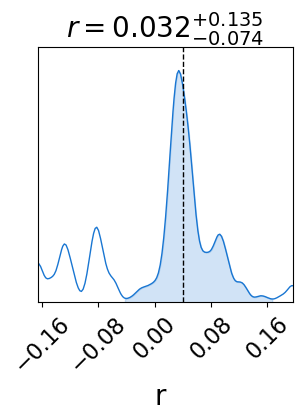

In [13]:
truths = [0.04]
print(f'truths = {truths}')

param_labels = ['r']

emcee_samples = sampler.get_chain(flat=True)

plt.clf()
# set up the object
c = ChainConsumer()
# add chain
c.add_chain(emcee_samples, parameters=param_labels)
c.configure(statistics='max', summary=True,
            label_font_size=20, tick_font_size=16,
            usetex=False, serif=False,
            #max_ticks=5, kde=True
            #sigmas=[0,1,2,3,4,5]
            )
fig = c.plotter.plot(truth=truths,
                     #extents=[(-10, 10), (-10, 10), (-10, 10)],
                     parameters=param_labels,
                     figsize=(3*npar, 3*npar))
ax_list = fig.axes
for ax in ax_list: ax.grid(False)

plt.show()

<Figure size 640x480 with 0 Axes>

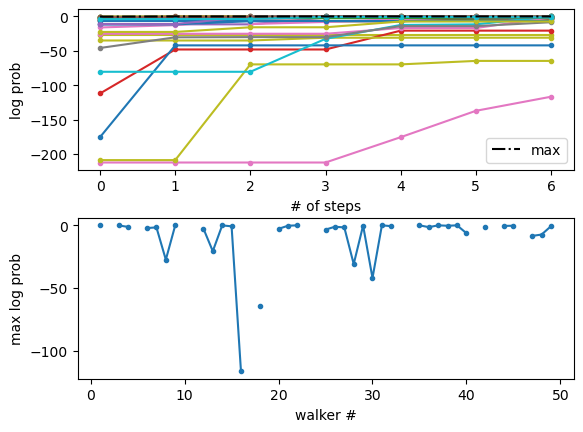

In [15]:
plt.clf()
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

ax = axes[0]
ax.plot(sampler.get_log_prob(), '.-')
ax.plot(np.max( sampler.get_log_prob(), axis=1), 'k-.', label='max')
ax.legend()
ax.set_xlabel('# of steps')
ax.set_ylabel('log prob')
#ax.set_yscale('log')

ax = axes[1]
ax.plot(np.max( sampler.get_log_prob(), axis=0), '.-')
ax.set_xlabel('walker #')
ax.set_ylabel('max log prob')

plt.show()

### SBI

In [11]:
import torch

In [7]:
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [17]:
num_dim = 1

param_priors = [[0.001, 1]]

prior = utils.BoxUniform(low=[param_priors[0][0]], high=[param_priors[0][1]])

prior

BoxUniform(Uniform(low: tensor([0.0010]), high: tensor([1.])), 1)

In [33]:
%%time

posterior = infer(get_theory, prior, method="SNPE", num_simulations=50)

updated InitPower.r in CAMBparams


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPower.r in CAMBparams
updated InitPo

/Users/humnaawan/anaconda3/envs/cmbcosmo/lib/python3.9/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 83 epochs.CPU times: user 12min 45s, sys: 8.31 s, total: 12min 54s
Wall time: 7min 11s


In [37]:
%%time

samples = posterior.sample((1000,), x=data)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.03 s, sys: 467 ms, total: 1.49 s
Wall time: 834 ms


In [38]:
%%time

log_probability = posterior.log_prob(samples, x=data)

CPU times: user 11.2 s, sys: 7.38 s, total: 18.6 s
Wall time: 12.4 s


truths = [0.04]


<Figure size 640x480 with 0 Axes>

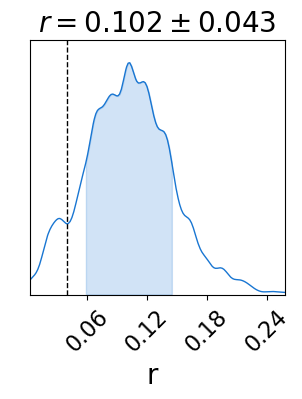

In [39]:
truths = [0.04]
npar = 1
print(f'truths = {truths}')

param_labels = ['r']

plt.clf()
# set up the object
c = ChainConsumer()
# add chain
c.add_chain(samples.cpu().detach().numpy(), parameters=param_labels)
c.configure(statistics='max', summary=True,
            label_font_size=20, tick_font_size=16,
            usetex=False, serif=False,
            #max_ticks=5, kde=True
            #sigmas=[0,1,2,3,4,5]
            )
fig = c.plotter.plot(truth=truths,
                     #extents=[(-10, 10), (-10, 10), (-10, 10)],
                     parameters=param_labels,
                     figsize=(3*npar, 3*npar))
ax_list = fig.axes
for ax in ax_list: ax.grid(False)

plt.show()